In [52]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import os
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Conv2DTranspose, concatenate, BatchNormalization
from tensorflow.keras.models import Model

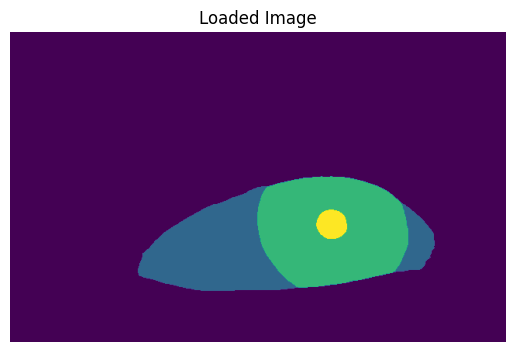

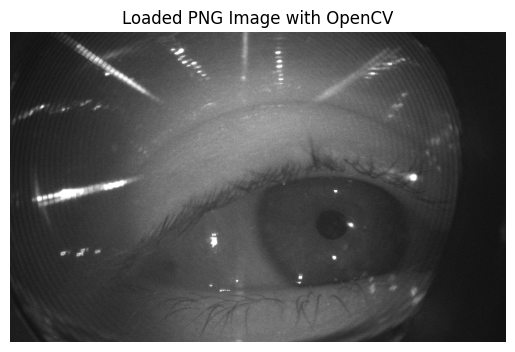

In [2]:
# Load the .npy file
label_file_path = '/home/yasas/MSC/Semester_3/PG research/gaze_estimation/archive/openEDS/openEDS/test/labels/000010.npy'
image_file_path =  '/home/yasas/MSC/Semester_3/PG research/gaze_estimation/archive/openEDS/openEDS/test/images/000010.png'

image_label = np.load(label_file_path)

# Display the image
plt.imshow(image_label)  # or remove cmap='gray' for a color image if applicable
plt.title('Loaded Image')
plt.axis('off')  # Optional: Turns off the axis
plt.show()

img = cv2.imread(image_file_path)

# OpenCV loads images in BGR format by default, so we convert it to RGB for correct display
img_rgb = cv2.cvtColor(img, cv2.IMREAD_COLOR)

# Display the image using matplotlib
plt.imshow(img_rgb)
plt.title('Loaded PNG Image with OpenCV')
plt.axis('off')  # Optional: Turns off the axis
plt.show()

In [3]:
def load_images_label_pairs(image_dir, label_dir):
    image_files = sorted(os.listdir(image_dir))  # Sort to maintain consistency
    label_files = sorted(os.listdir(label_dir))

    images =[]
    labels=[]

    currupted_images = [2355, 2365, 2366]
    print("Images count: " + str(len(image_files)))
    count = 0
    for img, label in zip(image_files, label_files):
        count += 1
        if(count in currupted_images):
            continue
        img_path = os.path.join(image_dir, img)
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)  # Adjust if images are colored
        img = cv2.resize(img, (256, 256))  # Resize if needed
        images.append(img)


        label_path = os.path.join(label_dir, label)
        label = np.load(label_path)
        label = cv2.resize(label, (256, 256))  # Resize to match the image size
        labels.append(label)


    return np.array(images), np.array(labels)


In [4]:
image_dir_path =  '/home/yasas/MSC/Semester_3/PG research/gaze_estimation/archive/openEDS/openEDS/test/images'
label_dir_path = '/home/yasas/MSC/Semester_3/PG research/gaze_estimation/archive/openEDS/openEDS/test/labels'
images, labels = load_images_label_pairs(image_dir_path, label_dir_path)

# # Normalize the images and labels
images = images / 255.0  # Normalize images between [0, 1]
labels = labels / np.max(labels)  # Normalize labels between [0, 1]

Images count: 2744


In [5]:
from sklearn.model_selection import train_test_split

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.2, random_state=42)


# Print the shapes of the resulting datasets
print(f"Training images shape: {X_train.shape}")
print(f"Training labels shape: {y_train.shape}")
print(f"Testing images shape: {X_test.shape}")
print(f"Testing labels shape: {y_test.shape}")



Training images shape: (2192, 256, 256)
Training labels shape: (2192, 256, 256)
Testing images shape: (549, 256, 256)
Testing labels shape: (549, 256, 256)


In [54]:
def unet_model(input_size=(256, 256, 1)):
    inputs = Input(input_size)
    
    # Encoder
    c1 = Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
    c1 = BatchNormalization()(c1)
    p1 = MaxPooling2D((2, 2))(c1)
    
    c2 = Conv2D(128, (3, 3), activation='relu', padding='same')(p1)
    c2 = BatchNormalization()(c2)
    p2 = MaxPooling2D((2, 2))(c2)
    
    # Bottleneck
    c3 = Conv2D(256, (3, 3), activation='relu', padding='same')(p2)
    
    # Decoder
    u4 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c3)
    u4 = concatenate([u4, c2])
    c4 = Conv2D(128, (3, 3), activation='relu', padding='same')(u4)
    c4 = BatchNormalization()(c4)
    
    u5 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c4)
    u5 = concatenate([u5, c1])
    c5 = Conv2D(64, (3, 3), activation='relu', padding='same')(u5)
    c5 = BatchNormalization()(c5)
    
    outputs = Conv2D(1, (1, 1), activation='sigmoid')(c5)
    
    model = Model(inputs, outputs)
    
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

# Create the U-Net model
unet = unet_model(input_size=(256, 256, 1))
unet.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3       │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_17 (Conv2D)  │ (None, 256, 256,  │        640 │ input_layer_3[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 256, 256,  │        256 │ conv2d_17[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_6     │ (None, 128, 128,  │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_18 (Conv2D)  │ (None, 128, 128,  │     73,856 │ max_pooling2d_6[… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128,  │        512 │ conv2d_18[0][0]   │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_7     │ (None, 64, 64,    │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_19 (Conv2D)  │ (None, 64, 64,    │    295,168 │ max_pooling2d_7[… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose_6  │ (None, 128, 128,  │    131,200 │ conv2d_19[0][0]   │
│ (Conv2DTranspose)   │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_6       │ (None, 128, 128,  │          0 │ conv2d_transpose… │
│ (Concatenate)       │ 256)              │            │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_20 (Conv2D)  │ (None, 128, 128,  │    295,040 │ concatenate_6[0]… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128,  │        512 │ conv2d_20[0][0]   │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose_7  │ (None, 256, 256,  │     32,832 │ batch_normalizat… │
│ (Conv2DTranspose)   │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_7       │ (None, 256, 256,  │          0 │ conv2d_transpose… │
│ (Concatenate)       │ 128)              │            │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_21 (Conv2D)  │ (None, 256, 256,  │     73,792 │ concatenate_7[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 256, 256,  │        256 │ conv2d_21[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_22 (Conv2D)  │ (None, 256, 256,  │         65 │ batch_normalizat

 Total params: 904,129 (3.45 MB)

 Trainable params: 903,361 (3.45 MB)

 Non-trainable params: 768 (3.00 KB)

In [55]:
history = unet.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=50,  # You can adjust the number of epochs
    batch_size=16,  # You can adjust the batch size
    shuffle=True
)

# Save the trained model
unet.save('unet_gaze_estimation_model.h5')

Epoch 1/50
137/137 ━━━━━━━━━━━━━━━━━━━━ 863s 6s/step - accuracy: 0.6952 - loss: 0.5775 - val_accuracy: 0.8552 - val_loss: 0.2704
Epoch 2/50
137/137 ━━━━━━━━━━━━━━━━━━━━ 862s 6s/step - accuracy: 0.8558 - loss: 0.1971 - val_accuracy: 0.8552 - val_loss: 0.3187
Epoch 3/50
137/137 ━━━━━━━━━━━━━━━━━━━━ 864s 6s/step - accuracy: 0.8596 - loss: 0.1370 - val_accuracy: 0.8552 - val_loss: 0.2787
Epoch 4/50
137/137 ━━━━━━━━━━━━━━━━━━━━ 866s 6s/step - accuracy: 0.8617 - loss: 0.1209 - val_accuracy: 0.8558 - val_loss: 0.2422
Epoch 5/50
137/137 ━━━━━━━━━━━━━━━━━━━━ 867s 6s/step - accuracy: 0.8606 - loss: 0.1141 - val_accuracy: 0.8618 - val_loss: 0.1223
Epoch 6/50
137/137 ━━━━━━━━━━━━━━━━━━━━ 869s 6s/step - accuracy: 0.8606 - loss: 0.1105 - val_accuracy: 0.8614 - val_loss: 0.1153
Epoch 7/50
137/137 ━━━━━━━━━━━━━━━━━━━━ 869s 6s/step - accuracy: 0.8612 - loss: 0.1063 - val_accuracy: 0.8589 - val_loss: 0.1127
Epoch 8/50
137/137 ━━━━━━━━━━━━━━━━━━━━ 870s 6s/step - accuracy: 0.8611 - loss: 0.1051 - val_accu

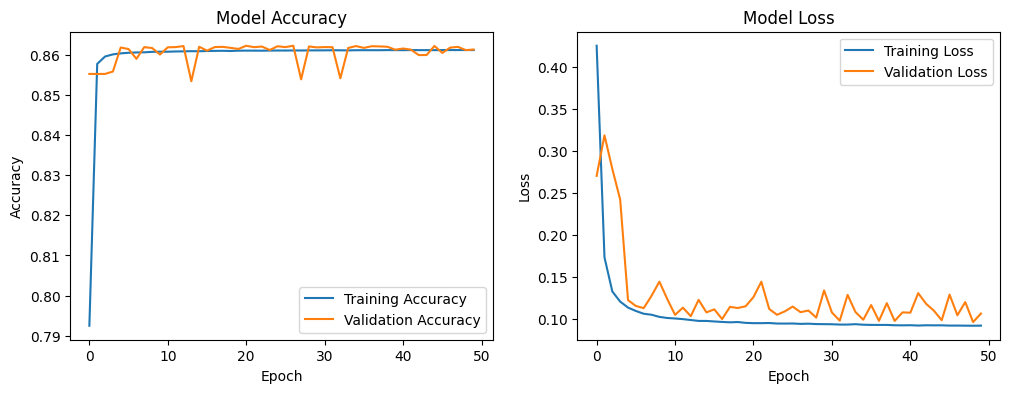

In [56]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy and loss
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()

2025-04-17 20:37:27.869060: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-04-17 20:37:27.970078: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-04-17 20:37:28.024258: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-04-17 20:37:28.035252: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-04-17 20:37:28.094146: I tensorflow/core/platform/cpu_feature_guar

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step


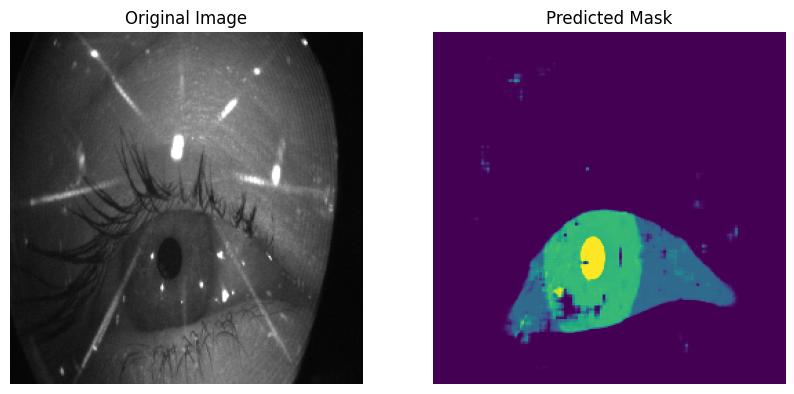

In [1]:
import numpy as np
import cv2
import tensorflow as tf
import matplotlib.pyplot as plt

# Load the trained U-Net model
model = tf.keras.models.load_model('unet_gaze_estimation_model.h5')

# Define the path to the image you want to predict
image_path = '/home/yasas/MSC/Semester_3/PG research/gaze_estimation/archive/openEDS/openEDS/test/images/020000.png'

# Load the image using OpenCV
image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)  # Assuming grayscale image

# Resize the image to the size expected by the model (e.g., 256x256)
image_resized = cv2.resize(image, (256, 256))

# Normalize the image to the [0, 1] range
image_normalized = image_resized/255

# Add a batch dimension and a channel dimension (required for model input)
input_image = np.expand_dims(image_normalized, axis=0)  # Shape: (1, 256, 256)
input_image = np.expand_dims(input_image, axis=-1)  # Shape: (1, 256, 256, 1)

# Predict the output using the model
predicted_mask = model.predict(input_image)

# Remove batch dimension to get the mask image
predicted_mask = predicted_mask[0, :, :, 0]  # Shape: (256, 256)

# Apply a threshold to convert the mask to binary (0 and 1) if needed
#predicted_mask_binary = (predicted_mask > 0.5).astype(np.uint8)

# Display the original image and the predicted mask side by side
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.imshow(image_resized, cmap='gray')
plt.title('Original Image')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(predicted_mask, cmap='viridis')
plt.title('Predicted Mask')
plt.axis('off')

plt.show()


In [41]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import (
    Input, Conv2D, Conv2DTranspose, BatchNormalization, Activation, concatenate
)
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler

# Dice Loss Function
def dice_loss(y_true, y_pred):
    smooth = 1.0
    intersection = tf.reduce_sum(y_true * y_pred)
    return 1 - (2. * intersection + smooth) / (tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) + smooth)

# Learning Rate Scheduler
def scheduler(epoch, lr):
    if epoch < 10:
        return lr
    else:
        return float(lr * tf.math.exp(-0.1))

# Optimized U-Net Model with Strided Convolutions
def unet_model(input_size=(256, 256, 1)):
    inputs = Input(input_size)

    # Encoder with Strided Convolutions
    c1 = Conv2D(64, (3, 3), padding='same', use_bias=False)(inputs)
    c1 = BatchNormalization()(c1)
    c1 = Activation('relu')(c1)
    p1 = Conv2D(64, (3, 3), strides=(2, 2), padding='same')(c1)

    c2 = Conv2D(128, (3, 3), padding='same', use_bias=False)(p1)
    c2 = BatchNormalization()(c2)
    c2 = Activation('relu')(c2)
    p2 = Conv2D(128, (3, 3), strides=(2, 2), padding='same')(c2)

    # Bottleneck
    c3 = Conv2D(256, (3, 3), padding='same', use_bias=False)(p2)
    c3 = BatchNormalization()(c3)
    c3 = Activation('relu')(c3)

    # Decoder with Transposed Convolutions
    u4 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c3)
    u4 = concatenate([u4, c2])
    c4 = Conv2D(128, (3, 3), padding='same', use_bias=False)(u4)
    c4 = BatchNormalization()(c4)
    c4 = Activation('relu')(c4)

    u5 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c4)
    u5 = concatenate([u5, c1])
    c5 = Conv2D(64, (3, 3), padding='same', use_bias=False)(u5)
    c5 = BatchNormalization()(c5)
    c5 = Activation('relu')(c5)

    outputs = Conv2D(1, (1, 1), activation='sigmoid')(c5)

    model = Model(inputs, outputs)
    model.compile(optimizer='adam', loss=dice_loss, metrics=['accuracy'])

    return model

# Instantiate the U-Net model
model = unet_model()

# Callbacks for Early Stopping and Learning Rate Scheduling
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
lr_scheduler = LearningRateScheduler(scheduler)

print(len(X_train))
# Assuming X_train, X_val, y_train, y_val are your data
history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=50,
    batch_size=16,
    callbacks=[early_stopping, lr_scheduler],
    shuffle=True
)


400
Epoch 1/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 157s 6s/step - accuracy: 0.6154 - loss: 0.7593 - val_accuracy: 0.0343 - val_loss: 0.8468 - learning_rate: 0.0010
Epoch 2/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 155s 6s/step - accuracy: 0.7413 - loss: 0.6357 - val_accuracy: 0.0206 - val_loss: 0.8523 - learning_rate: 0.0010
Epoch 3/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 155s 6s/step - accuracy: 0.8175 - loss: 0.4981 - val_accuracy: 0.4834 - val_loss: 0.8095 - learning_rate: 0.0010
Epoch 4/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 155s 6s/step - accuracy: 0.8283 - loss: 0.4469 - val_accuracy: 0.1408 - val_loss: 0.8317 - learning_rate: 0.0010
Epoch 5/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 156s 6s/step - accuracy: 0.8385 - loss: 0.4177 - val_accuracy: 0.0593 - val_loss: 0.8465 - learning_rate: 0.0010
Epoch 6/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 155s 6s/step - accuracy: 0.8392 - loss: 0.4013 - val_accuracy: 0.5356 - val_loss: 0.7794 - learning_rate: 0.0010
Epoch 7/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 201s 6s/step - accuracy: 0.8414 - loss: 0.3958 - val

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


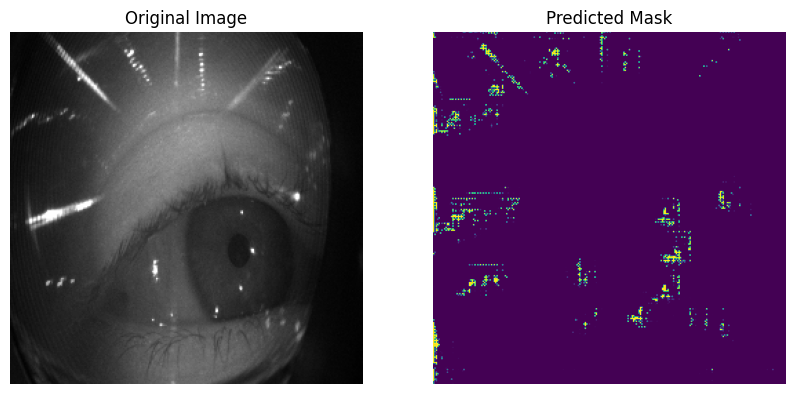

In [51]:
image_path = '/home/yasas/MSC/Semester_3/PG research/gaze_estimation/archive/openEDS/openEDS/test/images/000000.png'

# Load the image using OpenCV
image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)  # Assuming grayscale image

# Resize the image to the size expected by the model (e.g., 256x256)
image_resized = cv2.resize(image, (256, 256))

# Normalize the image to the [0, 1] range
image_normalized = image_resized / 255.0

# Add a batch dimension and a channel dimension (required for model input)
input_image = np.expand_dims(image_resized, axis=0)  # Shape: (1, 256, 256)
input_image = np.expand_dims(input_image, axis=-1)  # Shape: (1, 256, 256, 1)

# Predict the output using the model
predicted_mask = model.predict(input_image)

# Remove batch dimension to get the mask image
predicted_mask = predicted_mask[0, :, :, 0]  # Shape: (256, 256)

# # Apply a threshold to convert the mask to binary (0 and 1) if needed
# predicted_mask_binary = (predicted_mask > 0.5).astype(np.uint8)

# Display the original image and the predicted mask side by side
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.imshow(image_resized, cmap='gray')
plt.title('Original Image')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(predicted_mask, cmap='viridis')
plt.title('Predicted Mask')
plt.axis('off')

plt.show()